In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project_env as pe
import sklearn as sklearn
from scipy import stats
%matplotlib inline

In [2]:
val_risk = pd.read_csv('val_risk.csv', encoding = "ISO-8859-1", low_memory=False, index_col=False)

In [3]:
#bring in ADA_CODE, year/month of decision, target variable
data = pd.read_csv('merged.csv', encoding = "ISO-8859-1", low_memory=False)
data_simple = pd.read_csv('data_simple.csv', encoding = "ISO-8859-1", low_memory=False)
                          
                          
val_risk_merged = pd.merge(val_risk, \
                 data[['UNIQUE_ID','NEXT_ARREST_TIME','SCREENING_DISP_DATE','ARREST_DATE_y',\
                      'SCREENING_DISP_DATE_y','SCREENING_DISP_DATE_m']],\
                 on='UNIQUE_ID', \
                 how='left')
val_risk_merged = pd.merge(val_risk_merged, \
                 data_simple[['UNIQUE_ID','ADA_CODE']],\
                 on='UNIQUE_ID', \
                 how='left')


val_risk_merged['NEXT_ARREST_TIME'] = val_risk_merged['NEXT_ARREST_TIME'].apply(pd.to_numeric)

In [4]:
#Create target
_temp, val_risk_merged['REARREST'] = pe.create_target(val_risk_merged,5)
del _temp

In [7]:
#bring in screener info
by_sada = pd.read_csv('by_sada.csv', encoding = "ISO-8859-1", low_memory=False)
val_risk_merged = pd.merge(val_risk_merged, \
                 by_sada,\
                 on='ADA_CODE', \
                 how='left')

In [8]:
#drop if ADA_CODE is missing
val_risk_merged = val_risk_merged.dropna(axis=0, subset = ['ADA_CODE'])

In [87]:
def predicted_risk_dist(data, risk):
    df = data[data['RISK']>=risk]
    grouped = df.groupby('SCREENING_DISP_DATE_y')['SCREENING_DISP_DATE_y'].count()
    plt.bar(grouped.index, grouped.values)
    plt.xticks(grouped.index, grouped.index.map(str), rotation=45)
    plt.title('Number of Arrestees with Risk > %s' %risk)
    plt.ylabel('Screening Year')
    plt.tight_layout()
    plt.show()


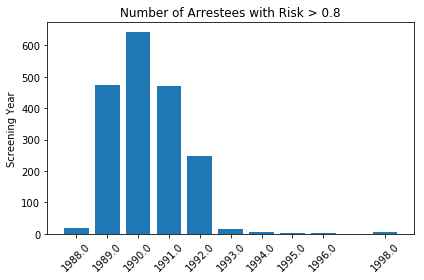

In [88]:
predicted_risk_dist(val_risk_merged,.80)

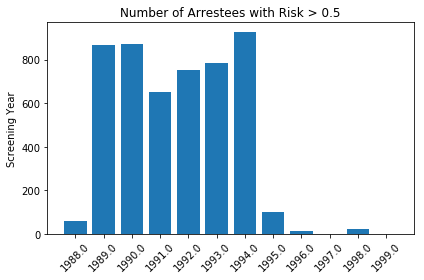

In [89]:
predicted_risk_dist(val_risk_merged,.50)

# Rank arrestees by risk and flag the marginal arrests to get to a given charge rate

In [35]:
charge_rate = .5

In [36]:
sada_l = by_sada.loc[by_sada['CHRG_RATE'] <= charge_rate].copy()
sada_l['n'] = ((charge_rate-sada_l['CHRG_RATE'])*sada_l['NBR_CASES']).apply(np.floor)

In [60]:
by_risk = val_risk_merged[['UNIQUE_ID','rank','RISK','ADA_CODE']].sort_values(['ADA_CODE','RISK'], ascending=[True,False])

In [61]:
by_risk['rank'] = by_risk.groupby('ADA_CODE').cumcount()

In [90]:
n = int(sada_l[sada_l['ADA_CODE']=='ADIC']['n'].values)
print(n,' additional charges')

155  additional charges


In [86]:
by_risk[(by_risk['ADA_CODE']=='ADIC')&(by_risk['rank']<=n)]

,UNIQUE_ID,rank,RISK,ADA_CODE
2082,115880,0,0.894902,ADIC
3464,90468,1,0.792724,ADIC
3682,179935,2,0.679448,ADIC
1209,178655,3,0.679448,ADIC
10021,188052,4,0.667715,ADIC
4151,180973,5,0.432897,ADIC
4379,72706,6,0.401932,ADIC
436,84654,7,0.375457,ADIC
2564,178663,8,0.332307,ADIC


In [69]:
by_risk[(by_risk['ADA_CODE']=='ADIC')]

,UNIQUE_ID,rank,RISK,ADA_CODE
2082,115880,0,0.894902,ADIC
3464,90468,1,0.792724,ADIC
3682,179935,2,0.679448,ADIC
1209,178655,3,0.679448,ADIC
10021,188052,4,0.667715,ADIC
4151,180973,5,0.432897,ADIC
4379,72706,6,0.401932,ADIC
436,84654,7,0.375457,ADIC
2564,178663,8,0.332307,ADIC


In [37]:
sada_list = sada_l['ADA_CODE'].unique()

In [71]:
for s in sada_list:
    '''
    n = number of charges that need to be filed to get to charge_rate
    '''
    n = int(sada_l[sada_l['ADA_CODE']=='ADIC']['n'].values)